<a href="https://colab.research.google.com/github/sanjanamasam1210/PixelPoetry-Image-Gen/blob/main/final_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade diffusers transformers timm torch torchvision -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 64.0 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from diffusers import StableDiffusionPipeline
from pathlib import Path

In [ ]:
class CFG:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    seed = 42
    generator = torch.Generator(device).manual_seed(seed)
    image_gen_steps = 35
    image_gen_model_id = "stabilityai/stable-diffusion-2"
    image_gen_size = (400, 400)
    image_gen_guidance_scale = 9
    output_dir = "./generated_images"  # Directory to save images
    batch_size = 16
    initial_epochs = 10
    additional_epochs = 5  # Additional epochs to train the model
    learning_rate = 0.001

In [ ]:
os.makedirs(CFG.output_dir, exist_ok=True)

In [ ]:
image_gen_model = StableDiffusionPipeline.from_pretrained(
    CFG.image_gen_model_id, torch_dtype=torch.float16,
    revision="fp16", use_auth_token='your_hugging_face_auth_token'
)
image_gen_model = image_gen_model.to(CFG.device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always

model_index.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:212: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
text_encoder/model.safetensors not found


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/815 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/900 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Keyword arguments {'use_auth_token': 'your_hugging_face_auth_token'} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
def generate_imagee(prompt, model):
    image = model(
        prompt, num_inference_steps=CFG.image_gen_steps,
        generator=CFG.generator,
        guidance_scale=CFG.image_gen_guidance_scale
    ).images[0]

    image = image.resize(CFG.image_gen_size)
    return image


In [ ]:
def generate_image(prompt, model, num_samples_per_word):
    dataset = []
    for word in prompt.split():
        for i in range(num_samples_per_word):
            image = model(
                word, num_inference_steps=CFG.image_gen_steps,
                generator=CFG.generator,
                guidance_scale=CFG.image_gen_guidance_scale
            ).images[0]
            image = image.resize(CFG.image_gen_size)
            dataset.append(image)
    return dataset

In [ ]:
def generate_combined_dataset(prompt, model, num_samples_per_word, output_dir):
    combined_dataset = []
    for word in prompt.split():
        word_dataset = []
        for i in range(num_samples_per_word):
            image = model(
                word, num_inference_steps=CFG.image_gen_steps,
                generator=CFG.generator,
                guidance_scale=CFG.image_gen_guidance_scale
            ).images[0]
            image = image.resize(CFG.image_gen_size)
            image_path = os.path.join(output_dir, f"{word}_{i+1}.png")
            image.save(image_path)  # Save the image
            word_dataset.append(image_path)
        combined_dataset.extend(word_dataset)
    return combined_dataset

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*50*50, 512)
        self.fc2 = nn.Linear(512, 10)  # Assuming 10 classes for simplicity

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 64*50*50)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
def train_model(model, dataloader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images in dataloader:
            images = images.to(CFG.device)
            labels = torch.zeros(images.size(0), dtype=torch.long).to(CFG.device)  # Dummy labels for illustration

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

In [ ]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [ ]:
prompt = "astronaut in space"

In [ ]:
dataset = generate_combined_dataset(prompt, image_gen_model, num_samples_per_word=5, output_dir=CFG.output_dir)


  0%|          | 0/35 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
image_dataset = CustomImageDataset(image_paths=dataset, transform=transform)
dataloader = DataLoader(image_dataset, batch_size=CFG.batch_size, shuffle=True)


In [ ]:
model = SimpleCNN().to(CFG.device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate)


In [ ]:
train_model(model, dataloader, criterion, optimizer, CFG.initial_epochs)

Epoch 1/10, Loss: 2.3289
Epoch 2/10, Loss: 0.0000
Epoch 3/10, Loss: 0.0000
Epoch 4/10, Loss: 0.0000
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000


In [ ]:
initial_model_path = "./initial_trained_model.pth"
save_model(model, initial_model_path)


In [ ]:
print(f"Initial model saved to {initial_model_path}")


Initial model saved to ./initial_trained_model.pth


In [ ]:
model.load_state_dict(torch.load(initial_model_path))

<All keys matched successfully>

In [ ]:
train_model(model, dataloader, criterion, optimizer, CFG.additional_epochs)

Epoch 1/5, Loss: 0.0000
Epoch 2/5, Loss: 0.0000
Epoch 3/5, Loss: 0.0000
Epoch 4/5, Loss: 0.0000
Epoch 5/5, Loss: 0.0000


In [ ]:
final_model_path = "./final_trained_model.pth"
save_model(model, final_model_path)

In [ ]:

print(f"Final trained model saved to {final_model_path}")

Final trained model saved to ./final_trained_model.pth


  0%|          | 0/35 [00:00<?, ?it/s]

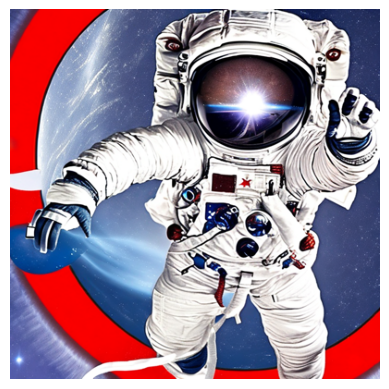

In [ ]:
new_image = generate_imagee(prompt, image_gen_model)
plt.imshow(new_image)
plt.axis('off')
plt.show()

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

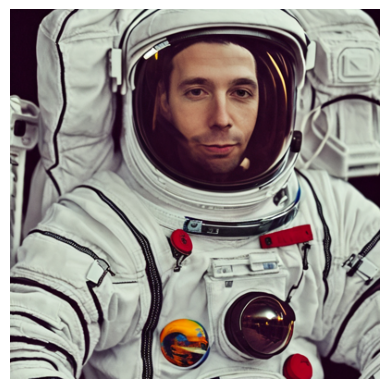

In [ ]:
new_image = generate_image(prompt, image_gen_model, num_samples_per_word=1)[0]
plt.imshow(new_image)
plt.axis('off')
plt.show()